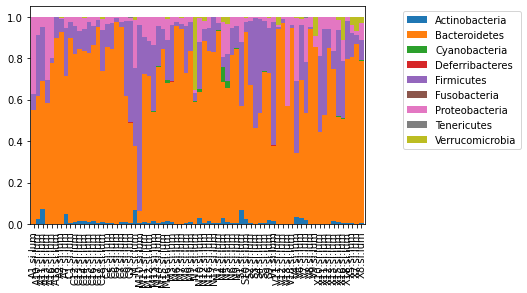

In [4]:
#code for the lumen. We gonna read the otulumen and from that get the abundances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
abu0=pd.read_csv("otulumen.csv")
tx0=pd.read_csv("lumentax.csv")
dfA=pd.DataFrame(abu0)
dfT=pd.DataFrame(tx0)
#uses the ID on the dfT dataframe, (left), and find it on the df dataframe, (right)
#the dataframe tax_abundance contains all the information: full taxonomy and the values of each sample#
tax_abundance=pd.merge(left=dfT,right=dfA,left_on='ID', right_on='ID')
#-------------------------
#dfA=tax_abundance.set_index('ID').T-->convenient way to transpose keeping the ID in the header
#list the name of columns in the dataframe df
#list(df.columns.values)
#now we drop the samples that have a total abundance <7000
modData=tax_abundance



from pandas.api.types import is_numeric_dtype

for column in modData.columns[8:]:
     if is_numeric_dtype(modData[column]):
        if sum(modData[column]) < 7000:
            modData.drop([column], axis=1, inplace=True)
#----------------------------
#-----now we normalize the samples in such a way each of them adds to 1

for column in modData.columns[8:]:
     if is_numeric_dtype(modData[column]):
        modData[column]=modData[column]/modData[column].sum()
#------------verification, we can comment this out
#for column in modData.columns[8:]:
#     if is_numeric_dtype(modData[column]):
#        ls=modData.sum(axis=0,skipna=True)
#        #check if everybody is normalized to one
#nd=modData.sum(numeric_only =True )
#for x in range(len(nd)):
#    print(nd[x]),
#---------------------------------



#-----------Block for sample <---> delivery correspondence-------------
#I start at 8 because the previous columns are taxonomy and  ID
headers=list(modData.columns[8:].values)
headers_list = pd.DataFrame(np.column_stack([headers]),columns=['SampleID'])
#------------
#now we convert the metada tsv file into a dataframe we can work with
# we seek a connection between the headers of tax_abundance with the delivery method listed in meta
tsv_file="metadata_SI_lumen.tsv"
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('meta_lumen.csv',index=False)
m0=pd.DataFrame( pd.read_csv("meta_lumen.csv") )
#-----Takes only the first two letters for delivery,e.g.: gavage->ga
#-----Use the single letter definition for antibiotics: A->ampicilin, N->Neomycin, X->mix....
m0['SampleID']=m0['#SampleID']
m0['treat']=m0['SampleID'].apply(lambda x: x[:1])+'-'+m0['treatment'].apply(lambda x: x[:2])
meta=m0[['SampleID']+['treat']]
#--------
#--treathead tells us wich deliver was used in each sample. Follows the sample order in modData
treathead=pd.merge(left=headers_list,right=meta,left_on='SampleID', right_on='SampleID')
#deliveryData replaces the .si.lum by the corresponding delivery in each sample
#deliveryData=modData.rename(columns=dict(zip(treathead.SampleID,treathead.treat)))
#-----------------------------------------------------------------------




#----now we tally the samples by desired tax level
#phylumData= modData.groupby("Phylum")["Order"].count()--tells us how many orders in the groups of phylum
groupData=modData.groupby("Phylum").sum().reset_index()
#groupData is currently grouping the entries by Phylum
#----------------------------------
#iloc[[i],[j]] gives u the i-row and j-column
#tax_abundance.iloc[[1],[8]]
#check point
#phylumData['A10.si.lum'].sum()
#--check point, normalization passed, all columns now add to 1
#---------------------------------------------
#now we select the columns to plot; the horizontal slices will follow the Phylum, so we set the index Phylum 
#and do a transpose
lst1=groupData[ ['Phylum']+ list(groupData.loc[:,'A1.si.lum':'X8.si.lum']) ].set_index('Phylum')
(lst1.T).plot(kind='bar',stacked=True,width=1).legend(bbox_to_anchor=(1.1, 1.0))

#------------------------------------------
#--lst2 is the barchart with the samples headers being the antibiotic with the delivery method
#lst2=lst1.rename(columns=dict(zip(treathead.SampleID,treathead.treat))).T
#lst2.plot(kind='bar',stacked=True,width=1).legend(bbox_to_anchor=(1.1, 1.0))
#missing: create a color-phylum reference table


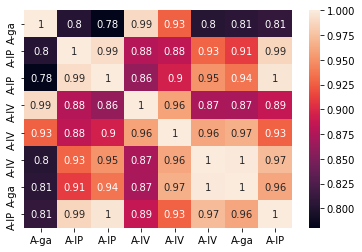

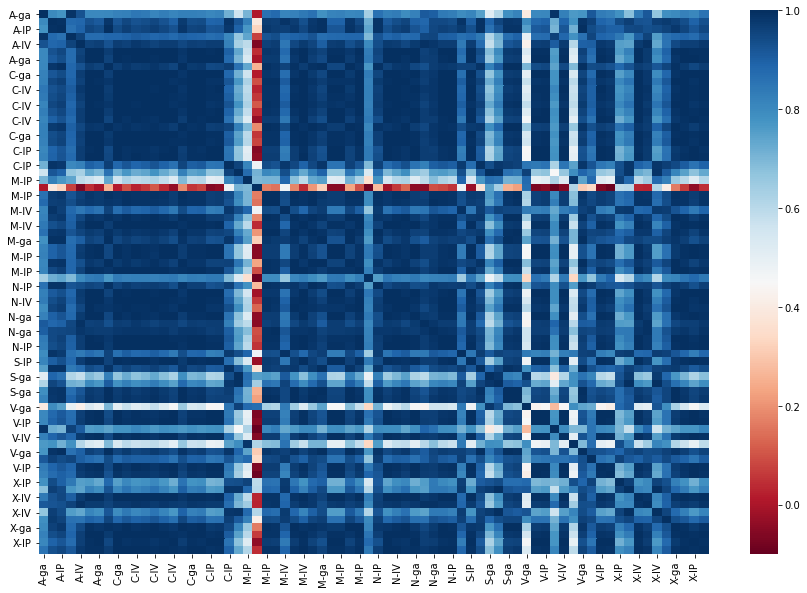

In [3]:
#takes only the AMP
ampMat=groupData[list(groupData.loc[:,'A1.si.lum':'A7.si.lum'])]
#takes only the Van
vanMat=groupData[list(groupData.loc[:,'V1.si.lum':'V9.si.lum'])]
mixMat=groupData[list(groupData.loc[:,'X10.si.lum':'X8.si.lum'])]
au=ampMat.rename(columns=dict(zip(treathead.SampleID,treathead.treat)))
#takes all the samples, from AMP to MIX
totalMat=groupData[list(groupData.loc[:,'A1.si.lum':'X8.si.lum'])]
totalU=totalMat.rename(columns=dict(zip(treathead.SampleID,treathead.treat)))
corrampMat=au.corr()#you can use ampMat instead of au to get the full sample indentifier .si.lum
corrtotal=totalMat.corr()

#--------------

import seaborn as sns
sns.heatmap(corrampMat, annot=True)
plt.show()
plt.figure(figsize=(15,10))
data=totalU
correlatedData = data.corr()
#turn annot=True to show the values in each square
sns.heatmap(round(correlatedData,3), cmap='RdBu', annot=False, 
            annot_kws={"size": 7}, vmin=-.1, vmax=1);

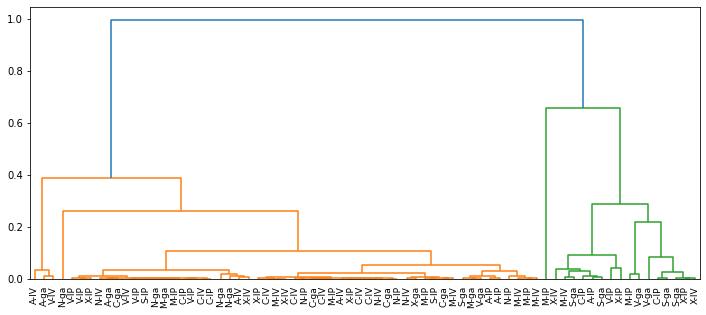

In [5]:
#part of hierarchical Clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.spatial import distance
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(data.corr())
#Z is the cluster linkage array, it contains the hierarchical clustering information
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=data.columns, orientation='top', 
           leaf_rotation=90,leaf_font_size=9);
# Clusterize the data
threshold = 0.9
labels = fcluster(Z, threshold, criterion='distance')
# Show the cluster
#labels
#a1=distance.jensenshannon(vanMat,mixMat) plt.plot(a1)

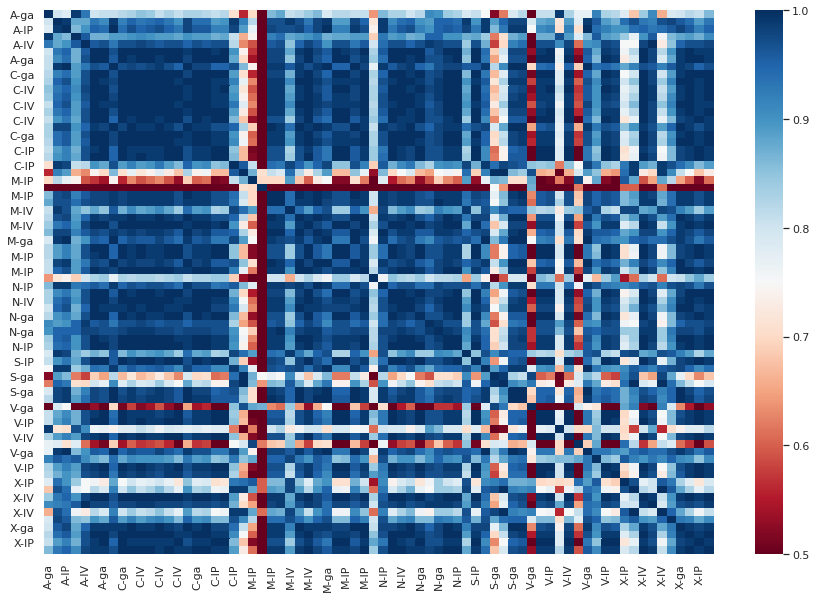

In [6]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(data[i])
    else:
        df_to_append = pd.DataFrame(data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

sns.set_theme(color_codes=True)
        
plt.figure(figsize=(15,10))
#correlations = clustered.corr()

sns.heatmap(round(correlatedData,2), cmap='RdBu', annot=False, 
           annot_kws={"size": 7}, vmin=.5, vmax=1); 




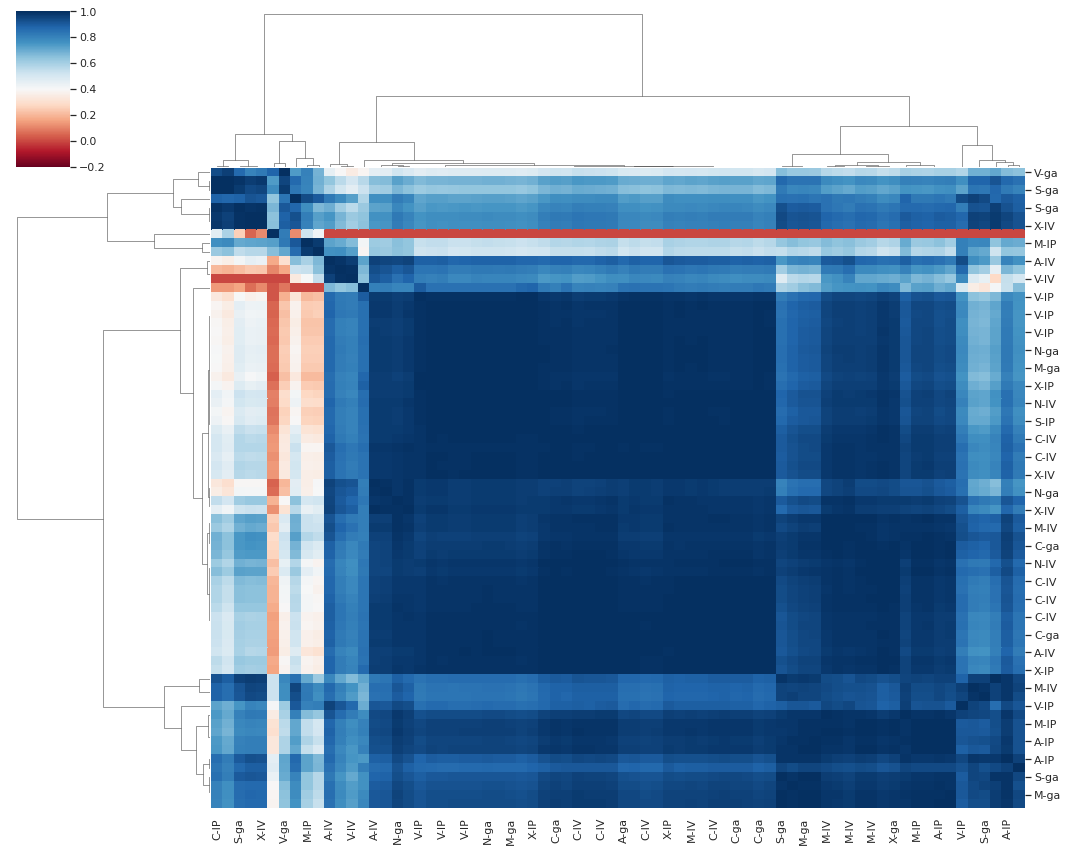

In [7]:
sns.clustermap(correlatedData, method="complete", cmap='RdBu', annot=False, standard_scale=1, metric="correlation",
               linewidth=.0,
               annot_kws={"size": 7}, vmin=-.2, vmax=1, figsize=(15,12));

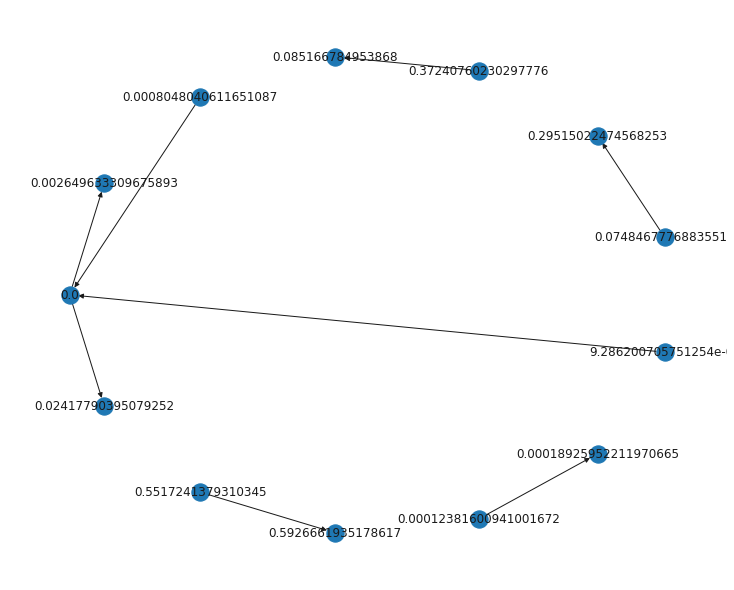

In [8]:
#test ---
import networkx as nx
G=nx.Graph()
G=nx.from_pandas_edgelist(totalMat,'A1.si.lum','A10.si.lum','X10.si.lum', create_using=nx.DiGraph())
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [ ]:
groupData